## SCF data cleaning and analysis 

- building on this [blog](https://notebook.community/DaveBackus/Data_Bootcamp/Code/Lab/SCF_data_experiment_Brian)

In [1]:
import pandas as pd   #The data package
import sys            #The code below wont work for any versions before Python 3. This just ensures that (allegedly).
assert sys.version_info >= (3,5)

In [2]:
import requests
import io
import zipfile      #Three packages we'll need to unzip the data
import matplotlib.pyplot as plt                            

In [3]:
"""
def unzip_survey_file(year = '2013'):
    
    #The next two lines of code converts the URL into a format that works
    #with the "zipfile" package.
    
    if int(year) <1989:
        url = 'http://www.federalreserve.gov/econresdata/scf/files/'+year+'_scf'+year[2:]+'bs.zip'
    
    else: 
        url = 'http://www.federalreserve.gov/econresdata/scf/files/scfp'+year+'s.zip'    
    url = requests.get(url)
    
    #Next, zipfile downloads, unzips, and saves the file to your computer. 'url2013_unzipped' 
    #contains the file path for the file.
    
    url_unzipped = zipfile.ZipFile(io.BytesIO(url.content))
    return url_unzipped.extract(url_unzipped.namelist()[0])
    
"""

'\ndef unzip_survey_file(year = \'2013\'):\n    \n    #The next two lines of code converts the URL into a format that works\n    #with the "zipfile" package.\n    \n    if int(year) <1989:\n        url = \'http://www.federalreserve.gov/econresdata/scf/files/\'+year+\'_scf\'+year[2:]+\'bs.zip\'\n    \n    else: \n        url = \'http://www.federalreserve.gov/econresdata/scf/files/scfp\'+year+\'s.zip\'    \n    url = requests.get(url)\n    \n    #Next, zipfile downloads, unzips, and saves the file to your computer. \'url2013_unzipped\' \n    #contains the file path for the file.\n    \n    url_unzipped = zipfile.ZipFile(io.BytesIO(url.content))\n    return url_unzipped.extract(url_unzipped.namelist()[0])\n    \n'

In [4]:
def unzip_survey_file(year = '2013'):
    """
    The next two lines of code converts the URL into a format that works
    with the "zipfile" package.
    """
    if int(year) <1989:
        url = 'http://www.federalreserve.gov/econres/files/'+year+'_scf'+year[2:]+'bs.zip'
    
    else: 
        url = 'http://www.federalreserve.gov/econres/files/scfp'+year+'s.zip'    
    url = requests.get(url)
    """
    Next, zipfile downloads, unzips, and saves the file to your computer. 'url2013_unzipped' 
    contains the file path for the file.
    """
    url_unzipped = zipfile.ZipFile(io.BytesIO(url.content))
    return url_unzipped.extract(url_unzipped.namelist()[0])

In [5]:
df2019 = pd.read_stata(unzip_survey_file(year='2019'))
df2016 = pd.read_stata(unzip_survey_file(year='2016'))
df2013 = pd.read_stata(unzip_survey_file(year='2013'))
#df2001 = pd.read_stata(unzip_survey_file(year = '2001'))
#df1983 = pd.read_stata(unzip_survey_file(year = '1983'))
#df1992 = pd.read_stata(unzip_survey_file(year = '1992'))


"""
There is no Summary Extract dataset for 1983, so we'll rename the variable names in the 1983 Full 
dataset so that they correspond to the variable names in the other survey years.

Also, 161 out of the 4262 total households covered in the 1983 survey actually reported having 
negative income. This isn't the case for the other survey years we are considering, and it 
complicates our analysis a bit below. Because of this, we drop any obs. that report negative 
incomes before proceeding. This has a near-zero impact on any of our results, since all but 2 
of these observations recieve a weight of zero. The two non-zero weight observations reporting
negative incomes account for only <0.05% of the total population, so not much is lost be 
excluding them.

Going forward: it might be worthwhile to figure out why there are instances of negative incomes
in the 1983 survey yet none for the other years. 
"""

#df1983 = df1983.rename(columns = {'b3201':'income', 'b3324':'networth', 'b3015' : 'wgt'})
#df1983 = df1983[df1983['income']>=0]

"\nThere is no Summary Extract dataset for 1983, so we'll rename the variable names in the 1983 Full \ndataset so that they correspond to the variable names in the other survey years.\n\nAlso, 161 out of the 4262 total households covered in the 1983 survey actually reported having \nnegative income. This isn't the case for the other survey years we are considering, and it \ncomplicates our analysis a bit below. Because of this, we drop any obs. that report negative \nincomes before proceeding. This has a near-zero impact on any of our results, since all but 2 \nof these observations recieve a weight of zero. The two non-zero weight observations reporting\nnegative incomes account for only <0.05% of the total population, so not much is lost be \nexcluding them.\n\nGoing forward: it might be worthwhile to figure out why there are instances of negative incomes\nin the 1983 survey yet none for the other years. \n"

<AxesSubplot:>

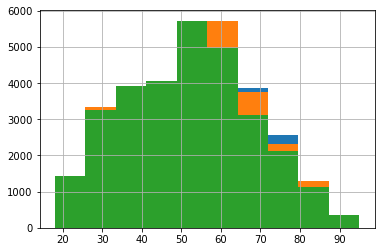

In [21]:
df2019['age'].hist()
df2016['age'].hist()
df2013['age'].hist()

In [23]:
def weighted_percentiles(data, variable, weights, percentiles = [], 
                         dollar_amt = False, subgroup = None, limits = []):
    """
    data               specifies what dataframe we're working with
    
    variable           specifies the variable name (e.g. income, networth, etc.) in the dataframe
    
    percentiles = []   indicates what percentile(s) to return (e.g. 90th percentile = .90)
    
    weights            corresponds to the weighting variable in the dataframe
    
    dollar_amt = False returns the percentage of total income earned by that percentile 
                       group (i.e. bottom 80% of earners earned XX% of total)
                         
    dollar_amt = True  returns the $ amount earned by that percentile (i.e. 90th percentile
                       earned $X)
                         
    subgroup = ''      isolates the analysis to a particular subgroup in the dataset. For example
                       subgroup = 'age' would return the income distribution of the age group 
                       determined by the limits argument
                       
    limits = []        Corresponds to the subgroup argument. For example, if you were interesting in 
                       looking at the distribution of income across heads of household aged 18-24,
                       then you would input "subgroup = 'age', limits = [18,24]"
                         
    """
    import numpy 
    a  = list()
    data[variable+weights] = data[variable]*data[weights]
    if subgroup is None:
        tt = data
    else:
        tt = data[data[subgroup].astype(int).isin(range(limits[0],limits[1]+1))] 
    values, sample_weight = tt[variable], tt[weights]
    
    for index in percentiles: 
        values = numpy.array(values)
        index = numpy.array(index)
        sample_weight = numpy.array(sample_weight)

        sorter = numpy.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

        weighted_percentiles = numpy.cumsum(sample_weight) - 0.5 * sample_weight
        weighted_percentiles /= numpy.sum(sample_weight)
        a.append(numpy.interp(index, weighted_percentiles, values))
    
    if dollar_amt is False:    
        return[tt.loc[tt[variable]<=a[x],
                      variable+weights].sum()/tt[variable+weights].sum() for x in range(len(percentiles))]
    else:
        return a

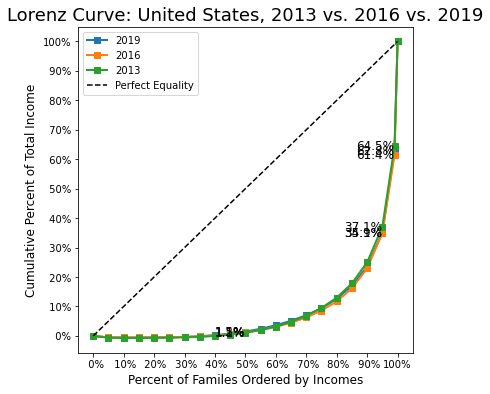

In [38]:
def figureprefs(data, variable = 'income', labels = False, legendlabels = []):
    
    percentiles = [i * 0.05 for i in range(20)]+[0.99, 1.00]

    fig, ax = plt.subplots(figsize=(6,6));

    ax.set_xticks([i*0.1 for i in range(11)]);       #Sets the tick marks
    ax.set_yticks([i*0.1 for i in range(11)]);

    vals = ax.get_yticks()                           #Labels the tick marks
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);
    ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals]);

    ax.set_title('Lorenz Curve: United States, 2013 vs. 2016 vs. 2019',  #Axes titles
                  fontsize=18, loc='center');
    ax.set_ylabel('Cumulative Percent of Total Income', fontsize = 12);
    ax.set_xlabel('Percent of Familes Ordered by Incomes', fontsize = 12);
    
    if type(data) == list:
        values = [weighted_percentiles(data[x], variable,
                    'wgt', dollar_amt = False, percentiles = percentiles) for x in range(len(data))]
        for index in range(len(data)):
            plt.plot(percentiles,values[index],
                     linewidth=2.0, marker = 's',clip_on=False,label=legendlabels[index]);
            for num in [10, 19, 20]:
                ax.annotate('{:3.1f}%'.format(values[index][num]*100), 
                    xy=(percentiles[num], values[index][num]),
                    ha = 'right', va = 'center', fontsize = 12);

    else:
        values = weighted_percentiles(data, variable,
                    'wgt', dollar_amt = False, percentiles = percentiles)
        plt.plot(percentiles,values,
                     linewidth=2.0, marker = 's',clip_on=False,label=legendlabels);

    plt.plot(percentiles,percentiles, linestyle =  '--', color='k',
            label='Perfect Equality');
   
    plt.legend(loc = 2)

years_graph = [df2019, df2016,df2013]
labels = ['2019', '2016','2013']

figureprefs(years_graph, variable = 'networth', legendlabels = labels);